# Optimization of Lennard-Jones potential for low density limit

In [1]:
%matplotlib inline
from itertools import product
import copy
import math
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd

## Properties as functions of conditions and LJ parameters

* Effective parameters
* Second virial coefficient
* Density
* Reduced collision integrals
* Viscosity

In [2]:
def pars_eff(sig, eps, T):
    """Effective temperature-dependent parameters"""
    
    # effective sigma & epsilon 
    alpha = 1.444*1e-30  # m^3
    mu = 1.855*3.1623e-25  # (J*m^3)^(1/2)
    kb = 1.380649e-23
    
    ST = 1 + 6*alpha*mu**2/(12*kb*1e-60)/(eps*sig**6)
    ST += mu**4/(12*kb**2*1e-60)/(T*eps*sig**6)
#    ST = 1.0988883 + 284.600188/T 

    sig_eff = sig*ST**(-1/6)
    eps_eff = eps*ST**2
    
    return sig_eff, eps_eff

In [79]:
def b2n(T, sig=1.0, eps=1.0, verbose=False):
    """Returns second virial coefficient of Lennard-Jones fluid

    Parameters
    ----------
    T : float
        Absolute temperature (K)
    sig : float
        Size parameter (Angstrom)
    eps : float
        Energy parameter (K)

    Returns
    -------
    b2 : float
        second virial coefficient (m^3/mol)
    """
    
    sig_eff, eps_eff = pars_eff(sig, eps, T)
    
    # Reduced temperature
    #Tr = T*8.314472/(eps*1000.0)
    Tr = T/eps_eff
    
    # Check if the reduced temperature is safe range
    if verbose and (Tr < 0.3 or Tr > 10000.0):
        print(f'Temperature {Tr} K is not in range 298-3000 K.')

    # Reduced virial coefficient
    
    Br = 7.8063*(1/Tr)**0.5 - 39.354*(1/Tr) + 92.147*(1/Tr)**1.5 - 121.58*(1/Tr)**2 
    Br += 72.269*(1/Tr)**2.5 - 0.37916*(1/Tr)**5 - 22.044*(1/Tr)**3.5 + 8.5833*(1/Tr)**4

#     Br  = 1.9863*Tr**(-0.25) - 1.5985*Tr**(-0.5) - 6.7636*Tr**(-1.5)
#     Br += 8.0952*Tr**(-2.0) - 4.8797*Tr**(-2.5) + 0.89417*Tr**(-3.5)
#     Br -= 0.25573*Tr**(-4.0)
#     Br -= 0.015386*Tr**(-5.0)

    Na = 6.0221409e23
    b0 = 2*np.pi*Na*(sig_eff*1e-10)**3/3
    
    B2 = Br*b0
    
    return B2

In [4]:
def density(P, T, b2):
    """
    Uses SI units
    """
    
    R = 8.314472
    rho = (-1 + np.sqrt(1 + 4*P*b2/(R*T))) / (2*b2)
    
    return rho

In [5]:
class Omega:
    """Collision integrals for Lennard-Jones potential"""
    
    def __init__(self, coeffs):
        if isinstance(coeffs, dict):
            self.coeffs = coeffs
        elif isinstance(coeffs, np.ndarray):
            self.coeffs = self.make_dict(coeffs)
        else:
            raise TypeError
            
    def make_dict(self, coeffs_array):
        """Creates a dictionary from supplied coefficient ndarray.
        
        Works for a particular structure of ndarray - should be modified
        if other format is used.
        """
        
        ls_tuples = [(1, i) for i in range(1, 8)] + [(2, i) for i in range(2, 7)] + [(3,3), (3,4), (3,5), (4,4)]
        b_list = [1, 3, 5, 8, 10, 6]
        c_list = [2, 4, 7, 9, 11, 12]
        b_fac = np.array([1., 1., 10., 10., 100., 1000.])
        c_fac = np.array([1., 10., 10., 100., 1000., 10000.])

        coeffs = {}
        for i in range(16):
            ls = ls_tuples[i]
            coeffs[ls] = {}
            coeffs[ls]['a'] = coeffs_array[0,i]
            coeffs[ls]['b'] = coeffs_array[b_list, i]/b_fac
            coeffs[ls]['c'] = coeffs_array[c_list, i]/c_fac

        return coeffs
        
    def get(self, Tr, l=1, s=1):
        """Returns collision integral for a given temperature"""
        coeff = self.coeffs[(l, s)]
        b = coeff['b']
        c = coeff['c']
        omega = coeff['a']
        omega += sum([b[k-1]*Tr**(-k) + c[k-1]*np.log(Tr)**k for k in range(1, 7)])
    
        return omega

In [6]:
# read data from file
omg = Omega(np.loadtxt('../data/raw/coeffs_num.txt'))

In [20]:
def viscosity(T, sig, eps):
    """Output in micro poise"""
    
    sig_eff, eps_eff = pars_eff(sig, eps, T)

    Tr = T/eps_eff
    
    om_22 = omg.get(Tr, 2, 2)
    om_23 = omg.get(Tr, 2, 3)
    f2 = 1 + 3/49*(4*om_23/om_22 - 7/2)**2
    
    kb = 1.38064852e-23
    Na = 6.0221409e23
    mw = 18*1e-3/Na  # kg/mol
    visc = 5*(mw*kb*T/np.pi)**0.5/(16*(sig_eff*1e-10)**2*om_22)*f2
    
    return visc*1e6

## Loss functions

In [127]:
def loss_rho(params, target):
    # ignoring prefactor V/(k_B)^3
    # If P is only one (P->0), it can be included in the prefactor
    loss = 0.0
    for P, T, b2_t, w in target:
        #if T < 647.0:
        if T < 1000.0:
            continue
        
        b2_m = b2n(T, params[0], params[1])

        loss += 1/8 * ((var_m - var_t)/var_t)**2  # 0.5**8

    return loss

In [143]:
def loss_b2_rho(params, target):
    # ignoring prefactor V/(k_B)^3
    # If P is only one (P->0), it can be included in the prefactor
    loss = 0.0
    for P, T, b2_t, w in target:
        #if T < 647.0:
        if T < 800.0:
            continue
        
        b2_m = b2n(T, params[0], params[1])

        loss += 1/8 * (b2_m - b2_t)**2  # 0.5**8

    return loss

In [144]:
def loss_b2_press(params, target):
    # ignoring prefactor V/(k_B)^3
    # If P is only one (P->0), it can be included in the prefactor
    loss = 0.0
    for P, T, b2_t, w in target:
        #if T < 647.0:
        if T < 800.0:
            continue
        
        b2_m = b2n(T, params[0], params[1])
        loss += 1/8 * (P/T)**2 * (b2_m - b2_t)**2  # * 0.5**8

    return loss

In [145]:
def loss_visc(params, target):
    # ignoring prefactor V/(k_B)^3
    # If P is only one (P->0), it can be included in the prefactor
    loss = 0.0
    for P, T, visc_t, w in target:
        if T < 800.0:
            continue
        
        visc_m = viscosity(T, params[0], params[1])
        #print(visc_m, visc_t)
        loss += 1/8*((visc_m - visc_t)/visc_t)**2

    return loss

In [146]:
def loss_combined(params, target_b2, target_visc, weights=[1.0, 1.0]):
    
    loss = 0.0
    loss += weights[0]*loss_b2_rho(params, target_b2)
    loss += weights[1]*loss_visc(params, target_visc)

    return loss

## Target data

* Second virial coefficient over a range of temperatures (i.e., low density equation of state)
* Low-density viscosities (eta_0)

In [147]:
b2_experiment = np.loadtxt('../data/raw/b2_h2o.txt')
# construct target data, with Pressure set to 1 Pa and b2 set in SI units (m^3/mol converted from cm^3/mol)
target_eos = [(1.0, T, b2*1e-6, 1.0) for T, b2 in b2_experiment]
#target_eos

In [148]:
visc = pd.read_csv('../data/raw/Hellmann_zero_visco.txt')
target_visc = visc[['T(K)','viscosity(micro-Pas)']].values
target_visc = np.array([(1., T, eta, 1.0) for T, eta in target_visc])
#target_visc

## Optimization

* Optimize over a range of temperatures

In [149]:
# initial parameters from Ariel (sigma (A), epsilon (K))
params_in = np.array([2.92, 293.7])

**Match low density EOS for different temperatures at constant density (second virial coefficients)**

In [150]:
result_rho = minimize(loss_b2_rho, params_in, method='Nelder-Mead', args=(target_eos,))
params_b2rho = result_rho['x']
result_rho

 final_simplex: (array([[  3.178787  , 349.75525788],
       [  3.17878733, 349.75532806],
       [  3.17878685, 349.75527306]]), array([1.5302055e-12, 1.5302055e-12, 1.5302055e-12]))
           fun: 1.530205497239068e-12
       message: 'Optimization terminated successfully.'
          nfev: 101
           nit: 52
        status: 0
       success: True
             x: array([  3.178787  , 349.75525788])

**Match low density EOS for different temperatures at constant pressure**

In [151]:
result_press = minimize(loss_b2_press, params_in, method='Nelder-Mead', args=(target_eos,))
params_b2press = result_press['x']
result_press

 final_simplex: (array([[  3.27299574, 358.95702154],
       [  3.27299458, 358.95694302],
       [  3.2729948 , 358.95701145]]), array([9.56636027e-19, 9.56636027e-19, 9.56636027e-19]))
           fun: 9.56636026814154e-19
       message: 'Optimization terminated successfully.'
          nfev: 116
           nit: 60
        status: 0
       success: True
             x: array([  3.27299574, 358.95702154])

**Match viscosities**

In [152]:
result_visc = minimize(loss_visc, params_in, method='Nelder-Mead', args=(target_visc,))
params_visc = result_visc['x']
result_visc

 final_simplex: (array([[  2.85729018, 336.97786475],
       [  2.85729025, 336.97779069],
       [  2.85729005, 336.97788471]]), array([1.96591878e-05, 1.96591878e-05, 1.96591878e-05]))
           fun: 1.9659187756868686e-05
       message: 'Optimization terminated successfully.'
          nfev: 96
           nit: 52
        status: 0
       success: True
             x: array([  2.85729018, 336.97786475])

**Match combined EOS and viscosities**

In [153]:
weights = [1e8, 1]
result_combined = minimize(loss_combined, params_in, method='Nelder-Mead', args=(target_eos, target_visc, weights))
params_combined = result_combined['x']
result_combined

 final_simplex: (array([[  2.91906245, 296.72001976],
       [  2.9190622 , 296.72011879],
       [  2.91906209, 296.7200389 ]]), array([0.00082009, 0.00082009, 0.00082009]))
           fun: 0.0008200927618525949
       message: 'Optimization terminated successfully.'
          nfev: 80
           nit: 42
        status: 0
       success: True
             x: array([  2.91906245, 296.72001976])

In [176]:
# Model virial coefficient
Temp = []
b2_target = []
b2_start = []
b2_press = []
b2_rho = []
b2_visc = []
b2_comb = []

for P, T, b2_t, w in target_eos:
    Temp.append(T)
    b2_target.append(b2_t*1e6)
    b2_start.append(b2n(T, params_in[0], params_in[1])*1e6)
    b2_press.append(b2n(T, params_b2press[0], params_b2press[1])*1e6)
    b2_rho.append(b2n(T, params_b2rho[0], params_b2rho[1])*1e6)
    b2_visc.append(b2n(T, params_visc[0], params_visc[1])*1e6)
    b2_comb.append(b2n(T, params_combined[0], params_combined[1])*1e6)

b2_target = np.array(b2_target)
b2_start = np.array(b2_start)
b2_press = np.array(b2_press)
b2_rho = np.array(b2_rho)
b2_visc = np.array(b2_visc)
b2_comb = np.array(b2_comb)

In [182]:
# Save data to a CSV file
data = []
for comp in zip(Temp, b2_target, b2_start, b2_rho, b2_visc, b2_comb):
    data.append(comp)

data = np.array(data)
df_b2 = pd.DataFrame(data)
df_b2.columns = ['Temp', 'B2_target', 'B2_Ariel', 'B2_from_B2', 'B2_from_viscosity', 'B2_combined']
df_b2.set_index('Temp', inplace=True)
#df_b2

Text(0.5, 1.0, 'Second virial coefficient optimized in T-range 1000 - 3000K')

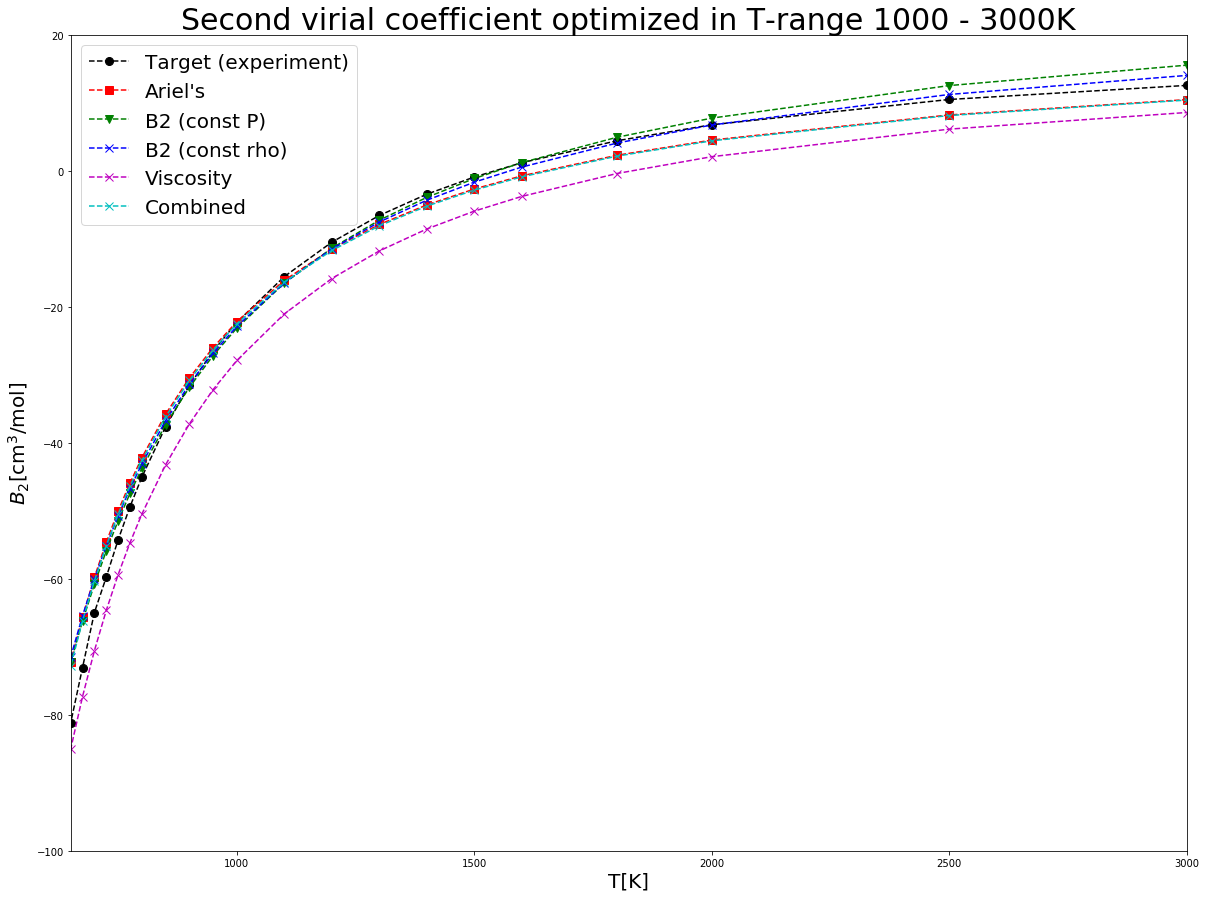

In [181]:
plt.figure(figsize=(20,15))
Temp = np.array(target_eos)[:,1]
plt.plot(Temp, b2_target, 'ko--', ms=8, label='Target (experiment)')
plt.plot(Temp, b2_start, 'rs--', ms=8, label='Ariel\'s')
plt.plot(Temp, b2_press, 'gv--', ms=8, label='B2 (const P)')
plt.plot(Temp, b2_rho, 'bx--', ms=8, label='B2 (const rho)')
plt.plot(Temp, b2_visc, 'mx--', ms=8, label='Viscosity')
plt.plot(Temp, b2_comb, 'cx--', ms=8, label='Combined')

plt.xlabel('T[K]', fontsize=20)
plt.ylabel('$B_2$[cm$^3$/mol]', fontsize=20)
plt.legend(fontsize=20)

plt.ylim(-100, 20)
plt.xlim(650,3000)
plt.title('Second virial coefficient optimized in T-range 1000 - 3000K', fontsize=30)

In [184]:
# Model virial coefficient
Temp = []
b2_target = []
b2_start = []
b2_press = []
b2_rho = []
b2_visc = []
b2_comb = []

for P, T, visc, w in target_visc:
    Temp.append(T)
    b2_target.append(visc)
    b2_start.append(viscosity(T, params_in[0], params_in[1]))
    b2_press.append(viscosity(T, params_b2press[0], params_b2press[1]))
    b2_rho.append(viscosity(T, params_b2rho[0], params_b2rho[1]))
    b2_visc.append(viscosity(T, params_visc[0], params_visc[1]))
    b2_comb.append(viscosity(T, params_combined[0], params_combined[1]))

b2_target = np.array(b2_target)
b2_start = np.array(b2_start)
b2_press = np.array(b2_press)
b2_rho = np.array(b2_rho)
b2_visc = np.array(b2_visc)
b2_comb = np.array(b2_comb)

In [186]:
# Save data to a CSV file
data = []
for comp in zip(Temp, b2_target, b2_start, b2_rho, b2_visc, b2_comb):
    data.append(comp)

data = np.array(data)
df_visco = pd.DataFrame(data)
df_visco.columns = ['Temp', 'eta_0_target', 'eta_0_Ariel', 'eta_0_from_B2', 'eta_0_from_viscosity', 'eta_0_combined']
df_visco.set_index('Temp', inplace=True)
df_visco

,eta_0_target,eta_0_Ariel,eta_0_from_B2,eta_0_from_viscosity,eta_0_combined
Temp,,,,,
300.0,9.7331,9.443198,8.516105,8.894309,9.427092
325.0,10.5960,10.362001,9.290950,10.244380,10.346577
350.0,11.4810,11.204480,10.101024,11.130453,11.186938
375.0,12.3890,12.080355,10.941753,11.963746,12.059830
400.0,13.3200,13.001819,11.807840,12.826171,12.977886
425.0,14.2740,13.966786,12.693743,13.728602,13.939138
450.0,15.2490,14.970759,13.594079,14.669841,14.939170
475.0,16.2440,16.008281,14.503897,15.646483,15.972609
500.0,17.2540,17.073372,15.418831,16.654327,17.033561


Text(0.5, 1.0, 'Viscosity coefficient optimized in T-range 1000 - 3000K')

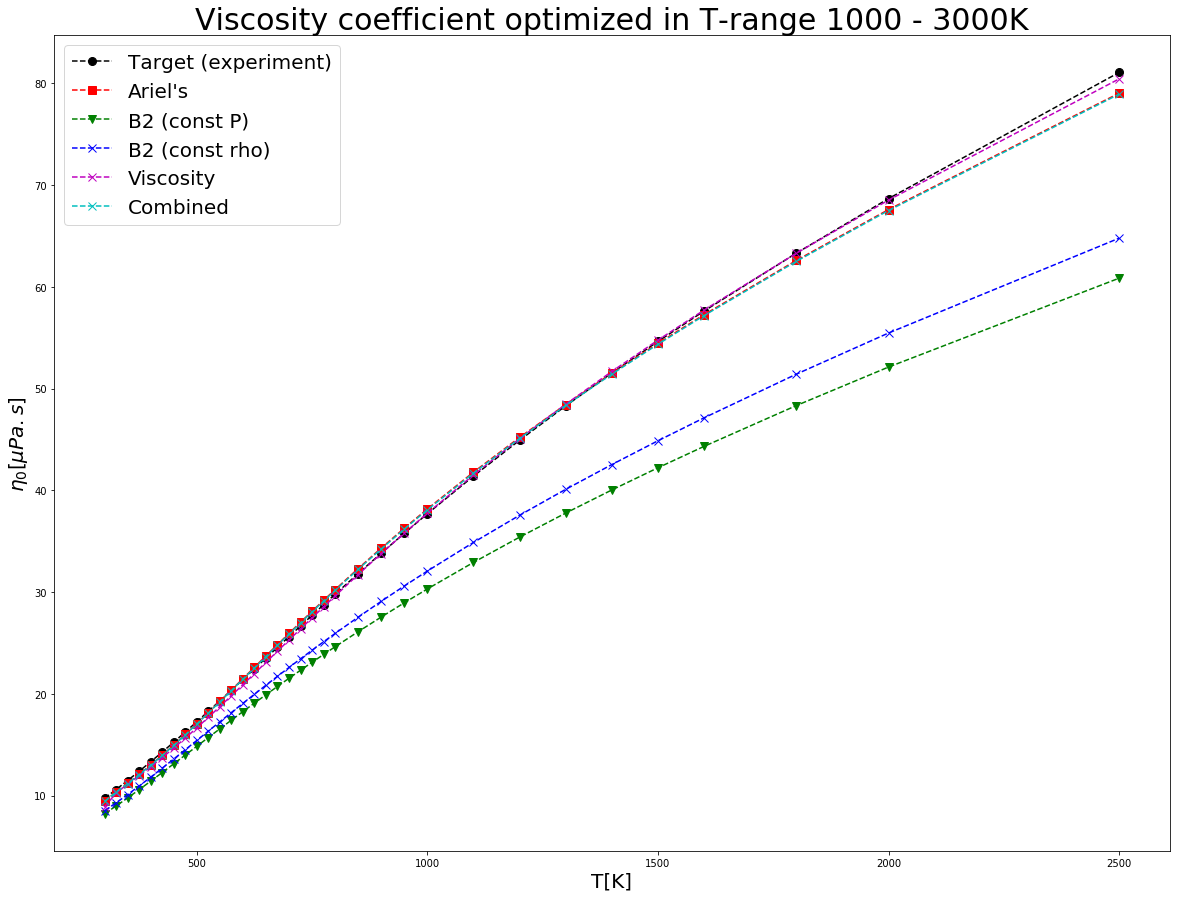

In [157]:
plt.figure(figsize=(20,15))
Temp = np.array(target_visc)[:,1]
plt.plot(Temp, np.array(target_visc)[:,2], 'ko--', ms=8, label='Target (experiment)')
plt.plot(Temp, b2_start, 'rs--', ms=8, label='Ariel\'s')
plt.plot(Temp, b2_press, 'gv--', ms=8, label='B2 (const P)')
plt.plot(Temp, b2_rho, 'bx--', ms=8, label='B2 (const rho)')
plt.plot(Temp, b2_visc, 'mx--', ms=8, label='Viscosity')
plt.plot(Temp, b2_comb, 'cx--', ms=8, label='Combined')

plt.xlabel('T[K]', fontsize=20)
plt.ylabel('$\eta_0{[\mu Pa.s]}$', fontsize=20)
plt.legend(fontsize=20)

#plt.ylim(-100, 20)
#plt.xlim(650,3000)
plt.title('Viscosity coefficient optimized in T-range 1000 - 3000K', fontsize=30)

In [162]:
sig_list = np.linspace(2.65, 3.25, 40)
eps_list = np.linspace(262., 359., 40)

n_sig = len(sig_list)
n_eps = len(eps_list)

b2_profiles = np.empty((n_sig, n_eps), dtype=float)
v2_profiles = np.empty((n_sig, n_eps), dtype=float)
c2_profiles = np.empty((n_sig, n_eps), dtype=float)

pars_profiles = np.empty((n_sig, n_eps, 2), dtype=float)
for i, j in product(range(n_sig), range(n_eps)):
    sig = sig_list[i]
    eps = eps_list[j]
    pars_in = np.array([sig, eps])

    b2 = loss_b2_rho(pars_in, target_eos)
    v2 = loss_visc(pars_in, target_visc)
    c2 = loss_combined(pars_in, target_eos, target_visc, weights)

    b2_profiles[i, j] = b2
    v2_profiles[i, j] = v2
    c2_profiles[i, j] = c2

    pars_profiles[i, j, :] = pars_in

[  2.91153846 296.82051282]


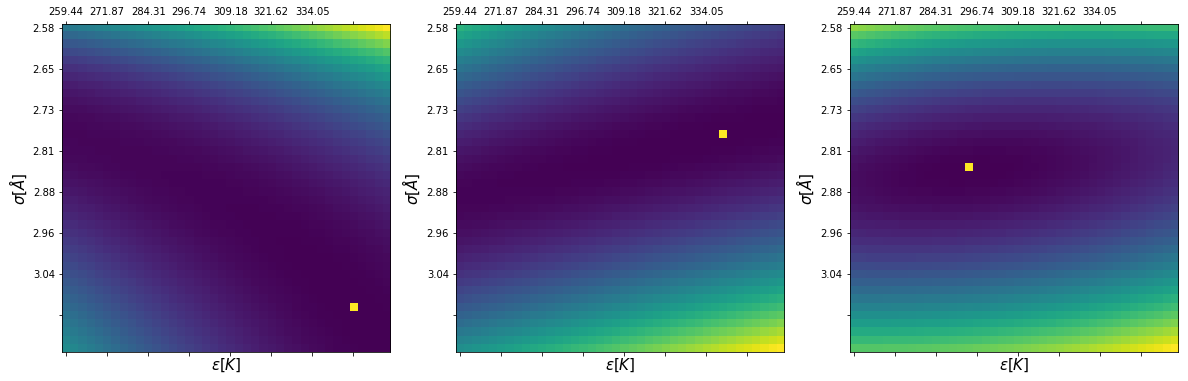

In [187]:
import matplotlib.ticker as ticker

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,10))
indices = np.unravel_index(np.argmin(b2_profiles, axis=None), b2_profiles.shape)
max_val = np.max(b2_profiles)
b2_profiles_x = copy.copy(b2_profiles)
b2_profiles_x[indices] = max_val
im = axes[0].matshow(b2_profiles_x)
axes[0].xaxis.set_major_locator(ticker.MultipleLocator(5))
axes[0].yaxis.set_major_locator(ticker.MultipleLocator(5))
axes[0].set_xticklabels([str(round(v-15, 2)) for v in eps_list[::5]])
axes[0].set_yticklabels([str(round(v-0.15, 2)) for v in sig_list[::5]])
axes[0].set_ylabel('$\sigma [\AA]$ ', fontsize=15)
axes[0].set_xlabel('$\epsilon [K]$', fontsize=15)

indices = np.unravel_index(np.argmin(v2_profiles, axis=None), v2_profiles.shape)
max_val = np.max(v2_profiles)
v2_profiles_x = copy.copy(v2_profiles)
v2_profiles_x[indices] = max_val
im = axes[1].matshow(v2_profiles_x)
axes[1].xaxis.set_major_locator(ticker.MultipleLocator(5))
axes[1].yaxis.set_major_locator(ticker.MultipleLocator(5))
axes[1].set_xticklabels([str(round(v-15, 2)) for v in eps_list[::5]])
axes[1].set_yticklabels([str(round(v-0.15, 2)) for v in sig_list[::5]])
axes[1].set_ylabel('$\sigma [\AA]$ ', fontsize=15)
axes[1].set_xlabel('$\epsilon [K]$', fontsize=15)

indices = np.unravel_index(np.argmin(c2_profiles, axis=None), c2_profiles.shape)
max_val = np.max(c2_profiles)
c2_profiles_x = copy.copy(c2_profiles)
c2_profiles_x[indices] = max_val
im = axes[2].matshow(c2_profiles_x)
axes[2].xaxis.set_major_locator(ticker.MultipleLocator(5))
axes[2].yaxis.set_major_locator(ticker.MultipleLocator(5))
axes[2].set_xticklabels([str(round(v-15, 2)) for v in eps_list[::5]])
axes[2].set_yticklabels([str(round(v-0.15, 2)) for v in sig_list[::5]])
axes[2].set_ylabel('$\sigma [\AA]$ ', fontsize=15)
axes[2].set_xlabel('$\epsilon [K]$', fontsize=15)

pars_optimal = pars_profiles[indices]
print(pars_optimal)
#axes.set_title('Total\n Optimal parameters: ' + str(params_dens), fontsize=20)

In [188]:
# save data to CSV files
df_b2.to_csv('../data/processed/b2.csv')
df_visco.to_csv('../data/processed/visco.csv')